In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from pathlib import Path
import glob
import random


Found 3 .npy files in train:
  - train/S2B_MSIL1C_20250619T101559_N0511_R065_T32UPU_20250619T124516.SAFE/data20.npy
  - train/S2B_MSIL1C_20250619T101559_N0511_R065_T32UPU_20250619T124516.SAFE/data20_gt.npy
  - train/S2B_MSIL1C_20250619T101559_N0511_R065_T32UPU_20250619T124516.SAFE/data10.npy

Visualizing first 3 files...
Comparing files side by side...
shape:  (8000, 6, 32, 32)
shape:  (8000, 6, 32, 32)
shape:  (8000, 4, 32, 32)


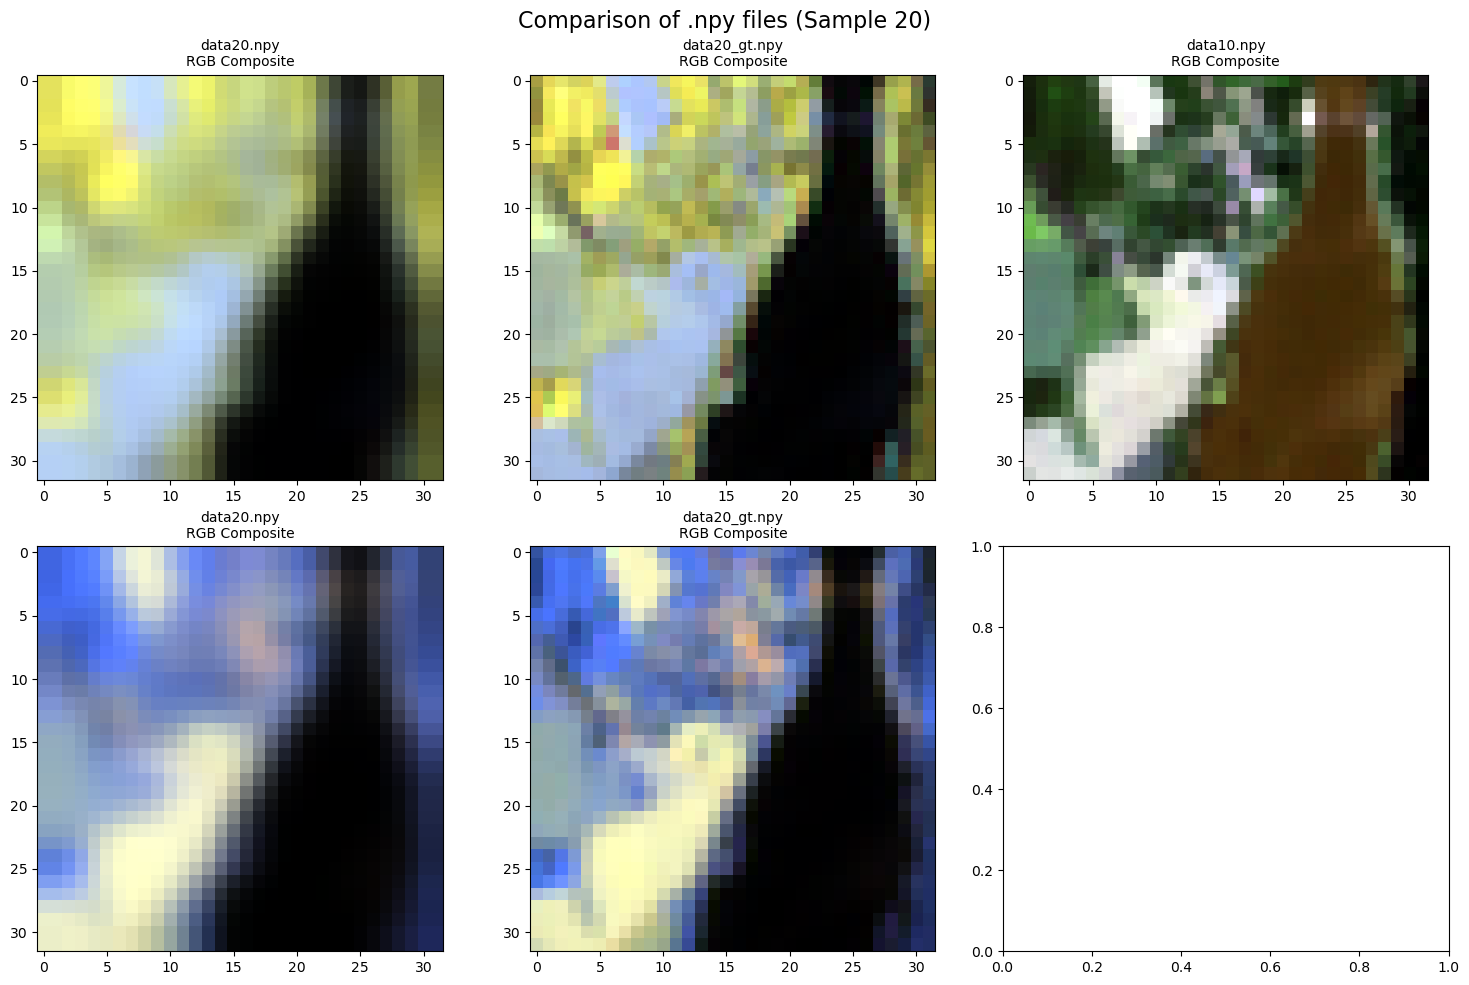

In [ ]:
def load_npy_data(filename):
    """Load .npy data with format [number of images, channels, w, h]"""
    try:
        data = np.load(filename)
        print("shape: ", data.shape)
        return data
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None

def normalize_band(band_data):
    """Normalize image data using percentile clipping"""
    if band_data is None or band_data.size == 0:
        return band_data
    
    # Clip to 1st and 99th percentiles to handle outliers
    p1, p99 = np.percentile(band_data, (1, 99))
    normalized = np.clip(band_data, p1, p99)
    
    # Normalize to [0, 1]
    if p99 > p1:
        normalized = (normalized - p1) / (p99 - p1)
    
    return normalized 

def visualize_npy_sample(data, sample_idx=0, filename="", max_bands=6):
    """Visualize a single sample from .npy data"""
    if data is None or len(data.shape) != 4:
        print("Invalid data format. Expected [images, channels, w, h]")
        print(data[0])
        return
    
    if sample_idx >= data.shape[0]:
        print(f"Sample index {sample_idx} out of range. Data has {data.shape[0]} samples")
        return
    
    sample = data[sample_idx]  # Shape: [channels, w, h]
    num_bands = min(sample.shape[0], max_bands)
    
    # Create subplot grid - only one row
    fig, axes = plt.subplots(nrows=1, ncols=num_bands, figsize=(4*num_bands, 4))
    if num_bands == 1:
        axes = [axes]
    
    fig.suptitle(f'Sample {sample_idx} from {filename}\nShape: {sample.shape}', fontsize=14)
    
    for i in range(num_bands):
        band_data = sample[i]  # Shape: [w, h]
        normalized = normalize_band(band_data)
        
        # Single row: grayscale
        im = axes[i].imshow(normalized, cmap='viridis')
        axes[i].set_title(f'Band {i+1}', fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    # print(f"\nStatistics for sample {sample_idx}:")
    # for i in range(num_bands):
    #     band_data = sample[i]
    #     print(f"Band {i+1}: min={band_data.min():.2f}, max={band_data.max():.2f}, "
    #           f"mean={band_data.mean():.2f}, std={band_data.std():.2f}")

def compare_npy_samples(filenames, max_files=4, sample_idx=0):
    
    """Compare multiple .npy files side by side"""
    if not filenames:
        print("No files provided")
        return
    
    files_to_show = filenames[:max_files]
    num_files = len(files_to_show)
    
    fig, axes = plt.subplots(nrows=2, ncols=num_files, figsize=(5*num_files, 10))
    if num_files == 1:
        axes = axes.reshape(2, 1)
    
    fig.suptitle(f'Comparison of .npy files (Sample {sample_idx})', fontsize=16)
    
    for i, filename in enumerate(files_to_show):
        data = load_npy_data(filename)
        if data is not None and sample_idx < data.shape[0]:
            sample = data[sample_idx]
            num_bands = min(sample.shape[0], 6)  # Show first 3 bands
            
            # Create RGB composite if we have at least 3 bands
            if num_bands == 6:
                height, width = sample.shape[1], sample.shape[2]
                rgb = np.zeros((height, width, 3))
                rgb2 = np.zeros((height, width, 3))
                rgb[:, :, 0] = normalize_band(sample[2])  # Red
                rgb[:, :, 1] = normalize_band(sample[1])  # Green
                rgb[:, :, 2] = normalize_band(sample[0])  # Blue

                rgb2[:, :, 0] = normalize_band(sample[5])  # Red
                rgb2[:, :, 1] = normalize_band(sample[4])  # Green
                rgb2[:, :, 2] = normalize_band(sample[3])  # Blue
                
                axes[0, i].imshow(rgb)
                axes[1, i].imshow(rgb2)
                axes[0, i].set_title(f'{os.path.basename(filename)}\nRGB Composite', fontsize=10)
                axes[1, i].set_title(f'{os.path.basename(filename)}\nRGB Composite', fontsize=10)
             
            elif num_bands == 4:
                height, width = sample.shape[1], sample.shape[2]
                rgb = np.zeros((height, width, 3))
                rgb[:, :, 0] = normalize_band(sample[2])  # Red
                rgb[:, :, 1] = normalize_band(sample[1])  # Green
                rgb[:, :, 2] = normalize_band(sample[0])  # Blue
                axes[0, i].imshow(rgb)
                axes[0, i].set_title(f'{os.path.basename(filename)}\nRGB Composite', fontsize=10)
               
            elif num_bands == 3 and i == 3: # This is the case of the last file real 60 m pixels images
                height, width = sample.shape[1], sample.shape[2]
                
                rgb = np.zeros((height, width, 3))
                rgb[:, :, 0] = normalize_band(sample[2])  # Red
                rgb[:, :, 1] = normalize_band(sample[1])  # Green
                rgb[:, :, 2] = normalize_band(sample[0])  # Blue
                
                axes[1, 0].imshow(rgb)
                axes[1, 0].set_title(f'{os.path.basename(filename)}\nRGB Composite', fontsize=10)
       
             

            elif num_bands == 3:
                height, width = sample.shape[1], sample.shape[2]
                
                rgb = np.zeros((height, width, 3))
                rgb[:, :, 0] = normalize_band(sample[2])  # Red
                rgb[:, :, 1] = normalize_band(sample[1])  # Green
                rgb[:, :, 2] = normalize_band(sample[0])  # Blue
                
                axes[0, i].imshow(rgb)
                axes[0, i].set_title(f'{os.path.basename(filename)}\nRGB Composite', fontsize=10)
                axes[0, i].axis('off')
                axes[1, i].axis('off')

            elif num_bands == 2:
                # Show first band in grayscale
                height, width = sample.shape[1], sample.shape[2]
                rgb = np.zeros((height, width, 3))
                rgb[:, :, 0] = normalize_band(sample[1])  # Red
                rgb[:, :, 1] = normalize_band(sample[0])  # Green
                rgb[:, :, 2] = normalize_band(sample[0])  # Blue
                
                axes[0, i].imshow(rgb)
                axes[0, i].set_title(f'{os.path.basename(filename)}\nRGB Composite', fontsize=10)
            else:
                # Show first band in grayscale
                normalized = normalize_band(sample[0])
                axes[0, i].imshow(normalized, cmap='gray')
                axes[0, i].set_title(f'{os.path.basename(filename)}\nBand 1', fontsize=10)
     
    
    plt.tight_layout()
    plt.show()

# Find all .npy files in train60 directory
train60_path = "train"
if os.path.exists(train60_path):
    npy_files = glob.glob(os.path.join(train60_path, "**/*.npy"), recursive=True)
    print(f"Found {len(npy_files)} .npy files in {train60_path}:")
    for file in npy_files:
        print(f"  - {file}")
    
    # Visualize first few files
    if npy_files:
        print(f"\nVisualizing first {min(3, len(npy_files))} files...")
        sample_idx = random.randint(0, 100)
        """
        for i, file in enumerate(npy_files[:4]):
            print(f"{'='*50}")
            print(f"File {i+1}: {file}")
            
            data = load_npy_data(file)
            if data is not None:
               visualize_npy_sample(data, sample_idx=sample_idx, filename=os.path.basename(file))
        """
        # Compare files side by side
       
        compare_npy_samples(npy_files[:4], max_files=4, sample_idx=sample_idx)
    else:
        print("No .npy files found in train60 directory")
else:
    print(f"Directory {train60_path} not found. Please check the path.")
